to do:
- remove hardcoding of folders/filenames
- change filessystem to pathlib
- remove unnecessary packages
- make markdown more comprehensive; include justification for design decision, such as when/when not to copy/paste
- improve comments: remove, cut down, add extra for unintuitive functions, like matrix loop at top of featuregen
- refactor slice code in generateFullFeatures()
- ???? design decision: to consolidated to into a singletest_samples_eng
- is there a more elegant way to delete object from ram than object = None
- include in readme: system limitations, dependencies, brief overview
- dependency graph on github
- reorder this notes 
- experiment fft, etc
- split pickling concsecutive/random sample pre-and post- feature generation
- edit the data visualisation to focus in on useful insights; move it to after running feature_importance on xgboost
- work on adjustment/justification for test_set data-leakage
- eliminate double -writing of xgboost params
- more explicit warnings for overwriting pickles

In [14]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

#my imports
import pathlib as path
import zipfile
import pickle
import random
import time
from scipy import stats
import scipy
import statistics
from torch.autograd import Variable

import keras
from keras.layers import GRU, Dense, Activation, Input
from keras.models import Sequential, Model
import tensorflow as tf

from xgboost import XGBRegressor
import seaborn as sns

from sklearn.model_selection import train_test_split
import lightgbm
import re
from pathlib import Path

# confirm code is run from folder /earthquake

In [2]:
os.chdir('/notebooks/storage/earthquake')
os.listdir()

['Model1000.pickle',
 'train_samples.pickle',
 'test_samples.pickle',
 'Xb.pickle',
 'train.csv',
 'features.zip',
 'YFFT_.pickle',
 'model2.pickle',
 'Model10000.pickle',
 'Ensemble.ipynb',
 'XY3.pickle',
 'Y.pickle',
 'Model100.pickle',
 'X100_.pickle',
 'Xbfft.pickle',
 'sandbox.ipynb',
 'consecutive_samples.pickle',
 'test.zip',
 'fft_Y.pickle',
 'Xcfft.pickle',
 'Modelfft1000.pickle',
 'Y_a.pickle',
 'Feature_Engineering.ipynb',
 'Y_.pickle',
 'Y_b.pickle',
 'submission.csv',
 'X10000_.pickle',
 'ensemble.zip',
 'pickle.ipynb',
 'XY1.pickle',
 'X10000_b.pickle',
 'Xc.pickle',
 'X10000_a.pickle',
 'Xa.pickle',
 'ensemble.pickle',
 'model1.pickle',
 'model_xgb.pickle',
 'Modelfft100.pickle',
 'X1000FFT_.pickle',
 'X1000.pickle',
 'refactor.ipynb',
 'SAMPLES_.pickle',
 'sample_submission.csv',
 'test_samples_eng.pickle',
 'X1000_.pickle',
 'X1.pickle',
 'X10000.pickle',
 'train.csv.zip',
 'X10000FFT_.pickle',
 'share',
 'Y_c.pickle',
 'Modelfft10000.pickle',
 'X100FFT_.pickle',
 'XY4

# download data from kaggle

In [ ]:
%%time
!kaggle competitions download LANL-Earthquake-Prediction

# unzip kaggle files

In [ ]:
%%time

train_zip='train.csv.zip'
test_zip='test.zip'
earthquake_dir='.'
test_dir='./test'

zip_ref=zipfile.ZipFile(train_zip,'r')
zip_ref.extractall(earthquake_dir)
zip_ref.close()

zip_ref=zipfile.ZipFile(test_zip,'r')
zip_ref.extractall(test_dir)
zip_ref.close()

# convert csv to dataframe

In [ ]:
%%time 

train = pd.read_csv('./train.csv', dtype={"acoustic_data": np.int16, "time_to_failure": np.float32})

# pickle train dataframe
NOTE: run once then comment out

In [ ]:
# %%time

# with open('/notebooks/storage/earthquake/train.pickle','wb') as f:
#     pickle.dump(train,f,pickle.HIGHEST_PROTOCOL)

CAUTION: code below will delete loaded train object from ram

In [ ]:
train = None

# load train dataframe

In [15]:
%%time

with open('/notebooks/storage/earthquake/train.pickle','rb') as f:
    train = pickle.load(f)

CPU times: user 1.04 s, sys: 5.09 s, total: 6.13 s
Wall time: 54.9 s


In [16]:
train.tail()

,acoustic_data,time_to_failure
629145475,7,9.759795
629145476,9,9.759795
629145477,10,9.759795
629145478,6,9.759795
629145479,5,9.759795


# generate consecutive samples

In [ ]:
def generateConsecutive(train):
    
    samples = []
    
    length = len(train)
    sample_length = 150000
    max_index = length-1
    max_start = max_index - sample_length
    
    for i in range(length//sample_length):
        
        start = i*sample_length
        end = (i+1)*sample_length
        
        samples += [[train['acoustic_data'].values[start:end],train['time_to_failure'].values[end]]]
                
    df = pd.DataFrame(samples)
        
    df = df.rename(columns = {0:'sequence',1:'ttf'})
    
    return df
    
    

In [ ]:
%%time

consecutive_samples = generateConsecutive(train)

In [ ]:
consecutive_samples.tail()

# generate N random samples

In [17]:
def generateRandom(train,n):
    
    samples = []
    
    length = len(train)
    sample_length = 150000
    max_index = length-1
    max_start = max_index - sample_length
    
    for i in range(n):
        
        start = random.randint(0,max_start)
        end = start + sample_length
        
        samples += [[np.array(train['acoustic_data'].values[start:end]),train['time_to_failure'].values[end]]]
                
    df = pd.DataFrame(samples)
        
    df = df.rename(columns = {0:'sequence',1:'ttf'})
    
    return df

In [18]:
%%time

random_samples = generateRandom(train,10)

CPU times: user 1.37 ms, sys: 5.7 ms, total: 7.06 ms
Wall time: 43.9 ms


In [19]:
random_samples.tail()

,sequence,ttf
5,"[5, 5, 4, 7, 9, 7, 4, 2, 8, 7, 4, 4, -2, 2, 2,...",6.572898
6,"[3, 2, 4, 7, 5, 4, 4, 4, 5, 3, 2, 4, 2, 3, 6, ...",2.380298
7,"[7, 5, 6, 4, 1, 4, 5, 3, 1, 2, 7, 4, 4, 7, 5, ...",13.955996
8,"[10, 15, 19, 7, 7, 1, -6, -3, -8, -8, 4, 13, 2...",1.604599
9,"[6, 8, 6, 3, 5, 3, -2, 4, 5, 2, 3, 2, 4, 4, 3,...",8.125196


# full sequence features

In [20]:
from scipy import fftpack

def generateFullFeatures(samples_df):
    
    #defining x as matrix of sequence data
    x = []
    for index,row in samples_df.iterrows():
        x += [samples_df.loc[index,'sequence']]    
    x = np.stack(x)
    x_abs = np.absolute(x)
    
    length=150000
    
    #non-abs
    samples_df['mean'] = np.mean(x,axis=1)
    samples_df['median'] = np.median(x,axis=1)
    samples_df['std'] = np.std(x,axis=1)
    
    samples_df['kurtosis'] = stats.kurtosis(x,axis=1)   
    samples_df['m2'] = stats.moment(x,axis=1,moment=2)
    samples_df['m3'] = stats.moment(x,axis=1,moment=3)
    samples_df['skew'] = stats.skew(x,axis=1)
    samples_df['variation'] = stats.variation(x,axis=1)
    samples_df['sem'] = stats.sem(x,axis=1)

    samples_df['iqr25_75'] = stats.iqr(x,axis=1,rng=(25,75))
    samples_df['iqr10_90'] = stats.iqr(x,axis=1,rng=(10,90))
    samples_df['iqr5_95'] = stats.iqr(x,axis=1,rng=(5,95))
    samples_df['iqr1_99'] = stats.iqr(x,axis=1,rng=(1,99))
    
    
    #abs
    samples_df['mean_abs'] = np.mean(x_abs,axis=1)
    samples_df['median_abs'] = np.median(x_abs,axis=1)
    samples_df['std_abs'] = np.std(x_abs,axis=1)
    
    samples_df['kurtosis_abs'] = stats.kurtosis(x_abs,axis=1)   
    samples_df['m2_abs'] = stats.moment(x_abs,axis=1,moment=2)
    samples_df['m3_abs'] = stats.moment(x_abs,axis=1,moment=3)
    samples_df['skew_abs'] = stats.skew(x_abs,axis=1)
    samples_df['variation_abs'] = stats.variation(x_abs,axis=1)
    samples_df['sem_abs'] = stats.sem(x_abs,axis=1)

    
    samples_df['iqr25_75_abs'] = stats.iqr(x_abs,axis=1,rng=(25,75))
    samples_df['iqr10_90_abs'] = stats.iqr(x_abs,axis=1,rng=(10,90))
    samples_df['iqr5_95_abs'] = stats.iqr(x_abs,axis=1,rng=(5,95))
    samples_df['iqr1_99_abs'] = stats.iqr(x_abs,axis=1,rng=(1,99))
    
    
    #slices
    slices_list = [2,4]
    
    for slices in slices_list:

        for i in range(slices):

            suffix = '_'+str(slices)+'_'+str(i+1)

            #create same as above, but for first half and second half
            
            # STYLE: DEFINE sliced_x at top of inner loop to make code prettier

            #non-abs
            samples_df['mean'+suffix] = np.mean(x[:,i*(length//slices):(i+1)*(length//slices)],axis=1)
            samples_df['median'+suffix] = np.median(x[:,i*(length//slices):(i+1)*(length//slices)],axis=1)
            samples_df['std'+suffix] = np.std(x[:,i*(length//slices):(i+1)*(length//slices)],axis=1)

            samples_df['kurtosis'+suffix] = stats.kurtosis(x[:,i*(length//slices):(i+1)*(length//slices)],axis=1)
            samples_df['m2'+suffix] = stats.moment(x[:,i*(length//slices):(i+1)*(length//slices)],axis=1,moment=2)
            samples_df['m3'+suffix] = stats.moment(x[:,i*(length//slices):(i+1)*(length//slices)],axis=1,moment=3)
            samples_df['skew'+suffix] = stats.skew(x[:,i*(length//slices):(i+1)*(length//slices)],axis=1)
            samples_df['variation'+suffix] = stats.variation(x[:,i*(length//slices):(i+1)*(length//slices)],axis=1)
            samples_df['sem'+suffix] = stats.sem(x[:,i*(length//slices):(i+1)*(length//slices)],axis=1)

            samples_df['iqr25_75'+suffix] = stats.iqr(x[:,i*(length//slices):(i+1)*(length//slices)],axis=1,rng=(25,75))
            samples_df['iqr10_90'+suffix] = stats.iqr(x[:,i*(length//slices):(i+1)*(length//slices)],axis=1,rng=(10,90))
            samples_df['iqr5_95'+suffix] = stats.iqr(x[:,i*(length//slices):(i+1)*(length//slices)],axis=1,rng=(5,95))
            samples_df['iqr1_99'+suffix] = stats.iqr(x[:,i*(length//slices):(i+1)*(length//slices)],axis=1,rng=(1,99))


            #abs
            samples_df['mean_abs'+suffix] = np.mean(x_abs[:,i*(length//slices):(i+1)*(length//slices)],axis=1)
            samples_df['median_abs'+suffix] = np.median(x_abs[:,i*(length//slices):(i+1)*(length//slices)],axis=1)
            samples_df['std_abs'+suffix] = np.std(x_abs[:,i*(length//slices):(i+1)*(length//slices)],axis=1)

            samples_df['kurtosis_abs'+suffix] = stats.kurtosis(x_abs[:,i*(length//slices):(i+1)*(length//slices)],axis=1)
            samples_df['m2_abs'+suffix] = stats.moment(x_abs[:,i*(length//slices):(i+1)*(length//slices)],axis=1,moment=2)
            samples_df['m3_abs'+suffix] = stats.moment(x_abs[:,i*(length//slices):(i+1)*(length//slices)],axis=1,moment=3)
            samples_df['skew_abs'+suffix] = stats.skew(x_abs[:,i*(length//slices):(i+1)*(length//slices)],axis=1)
            samples_df['variation_abs'+suffix] = stats.variation(x_abs[:,i*(length//slices):(i+1)*(length//slices)],axis=1)
            samples_df['sem_abs'+suffix] = stats.sem(x_abs[:,i*(length//slices):(i+1)*(length//slices)],axis=1)


            samples_df['iqr25_75_abs'+suffix] = stats.iqr(x_abs[:,i*(length//slices):(i+1)*(length//slices)],axis=1,rng=(25,75))
            samples_df['iqr10_90_abs'+suffix] = stats.iqr(x_abs[:,i*(length//slices):(i+1)*(length//slices)],axis=1,rng=(10,90))
            samples_df['iqr5_95_abs'+suffix] = stats.iqr(x_abs[:,i*(length//slices):(i+1)*(length//slices)],axis=1,rng=(5,95))
            samples_df['iqr1_99_abs'+suffix] = stats.iqr(x_abs[:,i*(length//slices):(i+1)*(length//slices)],axis=1,rng=(1,99))            
            

In [21]:
%%time

generateFullFeatures(random_samples)

CPU times: user 1.2 s, sys: 199 ms, total: 1.4 s
Wall time: 1.41 s


In [23]:
random_samples.tail()

,sequence,ttf,mean,median,std,kurtosis,m2,m3,skew,variation,...,kurtosis_abs_4_4,m2_abs_4_4,m3_abs_4_4,skew_abs_4_4,variation_abs_4_4,sem_abs_4_4,iqr25_75_abs_4_4,iqr10_90_abs_4_4,iqr5_95_abs_4_4,iqr1_99_abs_4_4
5,"[5, 5, 4, 7, 9, 7, 4, 2, 8, 7, 4, 4, -2, 2, 2,...",6.572898,4.471387,4.0,8.969663,130.742437,80.454848,-632.885586,-0.876995,2.006014,...,84.960700,175.640276,18503.650453,7.949160,1.874637,0.068439,4.0,10.0,16.0,72.00
6,"[3, 2, 4, 7, 5, 4, 4, 4, 5, 3, 2, 4, 2, 3, 6, ...",2.380298,4.646927,5.0,8.558958,215.763650,73.255759,-199.058574,-0.317481,1.841853,...,23.045453,19.974047,291.492453,3.265339,0.805980,0.023079,4.0,9.0,11.0,22.00
7,"[7, 5, 6, 4, 1, 4, 5, 3, 1, 2, 7, 4, 4, 7, 5, ...",13.955996,4.329807,4.0,3.875817,34.823375,15.021954,-0.192049,-0.003299,0.895148,...,15.267307,11.866582,97.499973,2.385152,0.703325,0.017789,4.0,8.0,9.0,16.00
8,"[10, 15, 19, 7, 7, 1, -6, -3, -8, -8, 4, 13, 2...",1.604599,4.771827,5.0,7.635642,45.775166,58.303030,-26.911984,-0.060452,1.600151,...,31.227866,56.823556,1907.093275,4.452248,1.096706,0.038927,5.0,11.0,17.0,42.01
9,"[6, 8, 6, 3, 5, 3, -2, 4, 5, 2, 3, 2, 4, 4, 3,...",8.125196,4.996893,5.0,6.065912,40.005736,36.795284,123.453785,0.553116,1.213937,...,5.023048,10.215210,38.839535,1.189606,0.594939,0.016505,4.0,7.0,10.0,15.00


# pickle samples

In [ ]:
# %%time

# with open('/notebooks/storage/earthquake/consecutive_samples.pickle','wb') as f:
#     pickle.dump(consecutive_samples,f,pickle.HIGHEST_PROTOCOL)

In [ ]:
consecutive_samples = None

# load samples

In [ ]:
%%time

with open('/notebooks/storage/earthquake/consecutive_samples.pickle','rb') as f:
    consecutive_samples = pickle.load(f)

In [ ]:
consecutive_samples.tail()

# visualize data

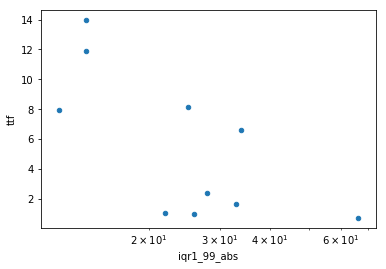

In [24]:
random_samples.plot(x='iqr1_99_abs',y='ttf',kind='scatter',logx=True)

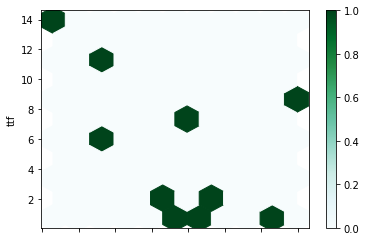

In [26]:
random_samples.plot.hexbin(x='mean',y='ttf',gridsize=10)

In [ ]:
sns.kdeplot(consecutive_samples['ttf'],consecutive_samples['mean'])

In [ ]:
sns.kdeplot(consecutive_samples.ttf)


In [ ]:
sns.jointplot(x='iqr1_99_abs',y='ttf',data=consecutive_samples,kind='hex',gridsize=10)

In [ ]:
sns.pairplot(consecutive_samples[['ttf','iqr1_99_abs','iqr5_95_abs','iqr10_90_abs']])

In [ ]:
# look into plotly for interactive plots, and ggplot for grammar of graphics

# split data into train/validation

In [27]:
public_mean = 4.017 
train_mean = 5.68
mul_factor = public_mean/train_mean


X = random_samples.drop(labels=['ttf','sequence'],axis=1)
Y = random_samples['ttf']/mul_factor

x_train, x_val, y_train, y_val = train_test_split(X,Y,test_size=.1,random_state=0,shuffle=False)

In [28]:
x_val.shape

(1, 182)

# XGBoost

In [31]:
%%time


n_estimators = 10000
learning_rate = .001
n_jobs = 8

early_stopping_rounds = 20
eval_set = [(x_val,y_val)]
verbose = True

model_xgb = XGBRegressor(
    n_estimators = n_estimators, 
    learning_rate = learning_rate, 
    n_job = n_jobs
)

model_xgb.fit(x_train,y_train,
              early_stopping_rounds= early_stopping_rounds,
              eval_set = eval_set,
              eval_metric = 'mae',
              verbose = verbose
             )

[21:25:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:10.983
Will train until validation_0-mae hasn't improved in 5 rounds.
[1]	validation_0-mae:10.9772
[2]	validation_0-mae:10.9713
[3]	validation_0-mae:10.9655
[4]	validation_0-mae:10.9529
[5]	validation_0-mae:10.9472
[6]	validation_0-mae:10.9416
[7]	validation_0-mae:10.936
[8]	validation_0-mae:10.9305
[9]	validation_0-mae:10.9249
[10]	validation_0-mae:10.9195
[11]	validation_0-mae:10.9141
[12]	validation_0-mae:10.9087
[13]	validation_0-mae:10.9033
[14]	validation_0-mae:10.8915
[15]	validation_0-mae:10.8863
[16]	validation_0-mae:10.8811
[17]	validation_0-mae:10.8759
[18]	validation_0-mae:10.8708
[19]	validation_0-mae:10.8657
[20]	validation_0-mae:10.8607
[21]	validation_0-mae:10.8557
[22]	validation_0-mae:10.8519
[23]	validation_0-mae:10.847
[24]	validation_0-mae:10.8421
[25]	validation_0-mae:10.8372
[26]	validation_0-mae:10.8324
[27]	validati

In [32]:
from sklearn.metrics import mean_absolute_error

predictions = model_xgb.predict(x_val)
print('mae : '+str(mean_absolute_error(predictions,y_val)))

mae : 10.541545790316661


# OVERWRITE pickle model

In [33]:
%%time

with open('/notebooks/storage/earthquake/model_xgb.pickle','wb') as f:
    pickle.dump(model_xgb,f,pickle.HIGHEST_PROTOCOL)

CPU times: user 613 µs, sys: 2.77 ms, total: 3.38 ms
Wall time: 245 ms


In [ ]:
model_xgb = None

# LOAD pickled model

In [3]:
%%time

with open('/notebooks/storage/earthquake/model_xgb.pickle','rb') as f:
    model_xgb = pickle.load(f)

[23:36:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 5.44 ms, sys: 42.6 ms, total: 48.1 ms
Wall time: 85.4 ms


# create submission
#### start with creating a dataframe identical in format to consecutive/random samples above

In [4]:
%%time

os.chdir('/notebooks/storage/earthquake/test')
# os.remove("submission.csv")
test_samples = pd.DataFrame(columns=['sequence','ttf'])

files = [x for x in os.listdir() if x[-4:] == '.csv']

for i in range(len(files)):
    
    test_file = files[i]
    
    temp_df = pd.read_csv('./'+test_file,engine='python')
        
    test_samples.loc[i,'sequence'] = np.array(temp_df['acoustic_data'].values[:])

CPU times: user 29min 31s, sys: 34.8 s, total: 30min 6s
Wall time: 30min 56s


In [5]:
test_samples.tail()

,sequence,ttf
2619,"[9, 4, 4, 5, 5, 0, 1, 0, 4, 9, 0, 4, 5, 2, 6, ...",NaN
2620,"[9, 7, 6, 2, 2, 2, 6, 5, 3, 2, 1, 4, 5, 4, 6, ...",NaN
2621,"[3, -3, -8, -9, -2, -3, 3, 9, 12, 13, 13, 17, ...",NaN
2622,"[-1, -1, 2, 9, 6, 7, 6, 6, 2, 0, -1, 4, 2, -1,...",NaN
2623,"[8, 4, 6, 5, 7, 10, 6, 5, 9, 2, 1, -1, 3, 2, 4...",NaN


# OVERWRITE pickle test sample df

In [6]:
# %%time

# with open('/notebooks/storage/earthquake/test_samples.pickle','wb') as f:
#     pickle.dump(test_samples,f,pickle.HIGHEST_PROTOCOL)

CPU times: user 1.48 s, sys: 5.77 s, total: 7.25 s
Wall time: 44.3 s


In [ ]:
test_samples = None

# LOAD pickled test sample df

In [34]:
%%time

with open('/notebooks/storage/earthquake/test_samples.pickle','rb') as f:
    test_samples = pickle.load(f)

CPU times: user 1.13 s, sys: 4.33 s, total: 5.45 s
Wall time: 51.1 s


# add features

In [9]:
%time

generateFullFeatures(test_samples)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


In [10]:
test_samples.tail()

,sequence,ttf,mean,median,std,kurtosis,m2,m3,skew,variation,...,kurtosis_abs_4_4,m2_abs_4_4,m3_abs_4_4,skew_abs_4_4,variation_abs_4_4,sem_abs_4_4,iqr25_75_abs_4_4,iqr10_90_abs_4_4,iqr5_95_abs_4_4,iqr1_99_abs_4_4
2619,"[9, 4, 4, 5, 5, 0, 1, 0, 4, 9, 0, 4, 5, 2, 6, ...",NaN,4.020207,4.0,6.166710,32.289924,38.028318,28.120282,0.119911,1.533929,...,10.412732,17.953910,174.051721,2.287914,0.820261,0.021881,5.0,9.0,12.0,21.0
2620,"[9, 7, 6, 2, 2, 2, 6, 5, 3, 2, 1, 4, 5, 4, 6, ...",NaN,4.231927,4.0,4.519961,30.960803,20.430043,14.891836,0.161267,1.068062,...,10.542928,10.892157,71.076163,1.977212,0.695970,0.017043,4.0,7.0,9.0,15.0
2621,"[3, -3, -8, -9, -2, -3, 3, 9, 12, 13, 13, 17, ...",NaN,4.284653,4.0,6.426391,45.338486,41.298506,-61.424123,-0.231439,1.499863,...,31.628445,32.708254,819.975421,4.383437,1.009892,0.029534,5.0,9.0,13.0,31.0
2622,"[-1, -1, 2, 9, 6, 7, 6, 6, 2, 0, -1, 4, 2, -1,...",NaN,4.468120,4.0,4.639209,26.310138,21.522264,6.088492,0.060979,1.038291,...,9.008973,9.972887,50.164873,1.592826,0.658598,0.016308,4.0,8.0,9.0,14.0
2623,"[8, 4, 6, 5, 7, 10, 6, 5, 9, 2, 1, -1, 3, 2, 4...",NaN,4.514920,5.0,5.768953,17.799390,33.280817,9.876277,0.051440,1.277753,...,10.417866,15.823663,138.687027,2.203308,0.752018,0.020542,4.0,9.0,11.0,20.0


# pickle engineered sample

In [11]:
# %%time

# with open('/notebooks/storage/earthquake/test_samples_eng.pickle','wb') as f:
#     pickle.dump(test_samples,f,pickle.HIGHEST_PROTOCOL)

CPU times: user 1.21 s, sys: 6.06 s, total: 7.27 s
Wall time: 9min 44s


In [13]:
test_samples = None

# load pickled engineered sample

In [14]:
%%time

with open('/notebooks/storage/earthquake/test_samples_eng.pickle','rb') as f:
    test_samples_eng = pickle.load(f)

CPU times: user 844 ms, sys: 2.38 s, total: 3.23 s
Wall time: 3.23 s


In [15]:
test_samples_eng.shape

(2624, 184)

# make predictions/submit

In [16]:
test_x = test_samples_eng.drop(columns=['sequence','ttf'])

y_pred = model_xgb.predict(test_x)

files = [x for x in os.listdir('/notebooks/storage/earthquake/test') if x[-4:] == '.csv']


In [17]:
y_pred.shape

(2624,)

In [18]:
submission_df = pd.DataFrame(columns=['seg_id','time_to_failure'])

In [19]:
submission_df['seg_id'] = pd.Series([i[:-4] for i in files])
submission_df.shape

(2624, 2)

In [20]:
submission_df['time_to_failure'] = y_pred

In [22]:
submission_df.tail()

,seg_id,time_to_failure
2619,seg_20a990,4.170691
2620,seg_a88dde,9.223204
2621,seg_2ea616,4.928998
2622,seg_0d833c,7.336555
2623,seg_ceb942,2.881655


In [ ]:
submission_df.to_csv('/notebooks/storage/earthquake/submission.csv',index=False)